In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor,IsolationForest,ExtraTreesRegressor,GradientBoostingRegressor

from sklearn import preprocessing
import scoring as score # para hacer los reportes de puntajes
from time import time

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes

properati = pd.read_csv('datos/properati_final.csv')
zonas = pd.read_csv('datos/todos_los_barrios.csv')

tipo_puntaje="neg_mean_squared_error"
iteraciones_de_searchs=20
cv=5

<IPython.core.display.Javascript object>

# Preprocesamiento

In [83]:
#paso features con strings a numericos
le_zona = preprocessing.LabelEncoder()
properati['state_name'] =le_zona.fit_transform(properati['state_name'])

le_barrio = preprocessing.LabelEncoder()
le_barrio.fit(zonas.values)
properati['place_name'] = le_barrio.transform(properati['place_name'])

le_tipo = preprocessing.LabelEncoder()
properati['property_type'] = le_tipo.fit_transform(properati['property_type'])

In [84]:
properati=properati.loc[properati.price_aprox_usd<1e]
properati=properati.loc[properati.surface_covered_in_m2<7000]
print len(properati)
properati=properati.groupby("place_name").filter(lambda x: len(x)>5)
print len(properati)

136327
135917


In [85]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['place_name'])
y = properati["price_aprox_usd"]

In [86]:
Z= zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['place_name'],properati["price_aprox_usd"])

outs = IsolationForest(n_jobs=-1,n_estimators=50)
outs.fit(Z)

len(Z)

nuevo_aux =zip(X,outs.predict(Z)) 

nuevo=[tupla for tupla in nuevo_aux if tupla[1]==1] #solo necesito lo que devuelve predecir Z y no el Z en si
print len(nuevo)
nuevo=[tupla[0] for tupla in nuevo_aux]
X=nuevo

122325


# XGBoost

In [103]:
%%notify
from xgboost import XGBRegressor
xgb= XGBRegressor(nthread=-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

learning_rate=np.arange(0.3,0.9,0.2)
gamma = np.arange(0.1,0.9,0.1)
subsample = [1]

param_grid = {"learning_rate": learning_rate,'min_child_weight':[1,3],'gamma':gamma,'subsample':subsample}

search = RandomizedSearchCV(xgb, param_distributions=param_grid ,cv=cv,n_iter=iteraciones_de_searchs,scoring=tipo_puntaje) 
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 134.43 segundos para 20 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: -16070066281.826 (std: 346293521.464)
Promedio validation score: -23716086612.888 (std: 1799688388.330)
Promedio fit time: 0.920s
Hiper-parametros: {'subsample': 1, 'learning_rate': 0.69999999999999996, 'gamma': 0.70000000000000007, 'min_child_weight': 3}

Puesto: 1
Promedio training score: -16070066281.826 (std: 346293521.464)
Promedio validation score: -23716086612.888 (std: 1799688388.330)
Promedio fit time: 0.920s
Hiper-parametros: {'subsample': 1, 'learning_rate': 0.69999999999999996, 'gamma': 0.59999999999999998, 'min_child_weight': 3}

Puesto: 1
Promedio training score: -16070066281.826 (std: 346293521.464)
Promedio validation score: -23716086612.888 (std: 1799688388.330)
Promedio fit time: 0.921s
Hiper-parametros: {'subsample': 1, 'learning_rate': 0.69999999999999996, 'gamma': 0.10000000000000001, 'min_child_weight': 3}

Puesto: 1
Promedio training score: -16070066281.82

<IPython.core.display.Javascript object>

In [104]:
xgboost = search.best_estimator_

# RF

In [89]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

criterion = ['mse']
max_features =["auto","log2",None]
n_estimators = np.arange(40,100,5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=cv,n_iter=iteraciones_de_searchs,scoring=tipo_puntaje) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 371.34 segundos para 20 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: -4082974876.781 (std: 125720663.809)
Promedio validation score: -20478988713.572 (std: 1940079580.514)
Promedio fit time: 2.268s
Hiper-parametros: {'n_estimators': 95, 'max_features': 'log2', 'criterion': 'mse'}

Puesto: 2
Promedio training score: -4160440258.237 (std: 68809977.649)
Promedio validation score: -20519977722.650 (std: 1946757677.998)
Promedio fit time: 1.345s
Hiper-parametros: {'n_estimators': 55, 'max_features': 'log2', 'criterion': 'mse'}

Puesto: 3
Promedio training score: -4123357590.929 (std: 141315619.742)
Promedio validation score: -20609040521.360 (std: 1956659284.226)
Promedio fit time: 2.080s
Hiper-parametros: {'n_estimators': 85, 'max_features': 'log2', 'criterion': 'mse'}

Puesto: 4
Promedio training score: -4064489517.962 (std: 140759157.442)
Promedio validation score: -20673448867.512 (std: 1569818492.098)
Promedio fit time: 1.995s
Hiper-parametros: {

<IPython.core.display.Javascript object>

In [90]:
rf= search.best_estimator_

In [91]:
search.score(X_test,y_test)

-19116725569.397343

# ETR

In [92]:
%%notify

etr = ExtraTreesRegressor(n_jobs=-1)

n_estimators = np.arange(40,100,5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"n_estimators":n_estimators}

search = GridSearchCV(etr, param_grid=param_grid ,cv=cv,scoring=tipo_puntaje) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 180.12 segundos para 12 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: -1778611336.720 (std: 113667004.116)
Promedio validation score: -22915836319.841 (std: 1679046258.834)
Promedio fit time: 1.736s
Hiper-parametros: {'n_estimators': 65}

Puesto: 2
Promedio training score: -1778534752.314 (std: 113643142.545)
Promedio validation score: -23083335823.027 (std: 1708920634.094)
Promedio fit time: 2.337s
Hiper-parametros: {'n_estimators': 90}

Puesto: 3
Promedio training score: -1778581372.589 (std: 113611681.753)
Promedio validation score: -23294097430.496 (std: 1410360717.354)
Promedio fit time: 1.132s
Hiper-parametros: {'n_estimators': 40}

Puesto: 4
Promedio training score: -1778627144.267 (std: 113547548.829)
Promedio validation score: -23305658676.229 (std: 1923610459.053)
Promedio fit time: 2.079s
Hiper-parametros: {'n_estimators': 80}

Puesto: 5
Promedio training score: -1778590574.218 (std: 113577698.267)
Promedio validation score: -2330729317

<IPython.core.display.Javascript object>

In [93]:
etr= search.best_estimator_

In [94]:
etr.feature_importances_

array([ 0.17646367,  0.63517484,  0.18836149])

# MLP

In [127]:
from sklearn.neural_network import MLPRegressor

In [128]:
%%notify

mlp = MLPRegressor()

#activation = ["identity", "logistic", "tanh", "relu"]
activation = ["identity"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"activation": activation}

search = GridSearchCV(mlp, param_grid=param_grid ,cv=cv,scoring=tipo_puntaje) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 64.37 segundos para 1 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: -48649291414.936 (std: 1278210409.982)
Promedio validation score: -48843115430.570 (std: 5226556298.293)
Promedio fit time: 10.628s
Hiper-parametros: {'activation': 'identity'}



<IPython.core.display.Javascript object>

In [129]:
mlp=search.best_estimator_

In [130]:
search.score(X_test,y_test)

-43791592775.715477

# Lineales

In [118]:
from sklearn.linear_model import Ridge

In [119]:
%%notify

ridge = Ridge()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

ridge.fit(X_train, y_train)
ridge.score(X_test,y_test)

0.47329439411938912

<IPython.core.display.Javascript object>

In [201]:
from sklearn.linear_model import Lasso

In [202]:
%%notify

lasso = Lasso()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

lasso.fit(X_train, y_train)
lasso.score(X_test,y_test)

0.54375167665157176

<IPython.core.display.Javascript object>

# Ensamble

In [224]:
from mlxtend.regressor import StackingRegressor

stregr = StackingRegressor(regressors=[rf,etr,ridge,lasso], 
                           meta_regressor=xgb)

In [225]:
%%notify
stregr.fit(X_train,y_train)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


StackingRegressor(meta_regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
         regressors=[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estima...eg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)],
         verbose=0)

<IPython.core.display.Javascript object>

In [226]:
stregr.score(X_test,y_test)

0.77880627435285699

In [227]:
errores = rf.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:2536683.57895
Error minimo:0.0
46813          0.000000
93959       6646.491228
118919     -9136.842105
18577       3498.802591
96013      -1812.107206
101086     16661.403509
88434      -2357.894737
91457       9848.453688
39044       -527.368421
67554      42280.821053
53011      42252.631579
116624     21018.421053
123884    -11090.643161
71944     -11947.368421
48596     -76213.868003
129025    -58012.873684
66471     -18546.867669
90600       8663.157895
122238    -13340.968421
16725      -8541.902834
22691      -7998.370927
79794      62869.780952
1524        4521.825397
105253      6271.052632
134940    -24815.177945
46357      48011.957166
91342       4379.484211
90637        954.550977
78381      13964.028571
16729      -8338.383459
              ...      
51284       -376.954150
87793       1505.413534
133023     63452.631579
47528     -33628.434946
48927      14168.421053
45187       3379.526234
44995       6100.582245
130574      -502.413118
111155    -71519.542

In [228]:
count_max=0
max_error=1000
lista=[]
for error in errores:
    if abs(error)>max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max/len(errores)))

Hay 25391 de 27184 que tienen mas de 1000 USD de error (93%)


In [229]:
count_max=0
max_error=5000
lista=[]
for error in errores:
    if abs(error)>max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max/len(errores)))

Hay 20164 de 27184 que tienen mas de 5000 USD de error (74%)


In [230]:
count_max=0
max_error=10000
lista=[]
for error in errores:
    if abs(error)>max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max/len(errores)))

Hay 15770 de 27184 que tienen mas de 10000 USD de error (58%)


### Errores arriba del maximo

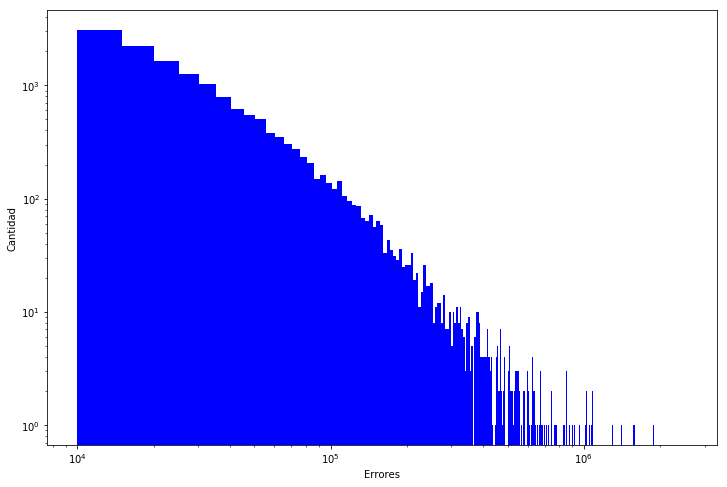

In [222]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(lista, 500, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-10000000, 10000000) #para variar el "zoom a 0"
plt.yscale('log')
plt.xscale('log')
plt.show()

### Errores totales

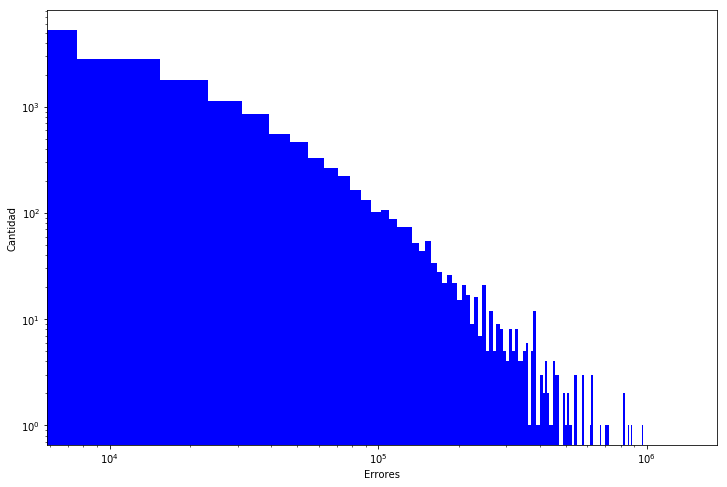

In [223]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 500, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-10000000, 10000000) #para variar el "zoom a 0"
plt.yscale('log')
plt.xscale('log')
plt.show()

# Kaggle

In [212]:
test_samples=pd.read_csv("datos/properati_dataset_testing_noprice_acondicionado.csv")
test_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 17 columns):
id                         14166 non-null int64
created_on                 14166 non-null object
property_type              14166 non-null object
operation                  14166 non-null object
place_name                 14166 non-null object
place_with_parent_names    14166 non-null object
country_name               14166 non-null object
state_name                 14166 non-null object
lat-lon                    10487 non-null object
lat                        10487 non-null float64
lon                        10487 non-null float64
surface_total_in_m2        14166 non-null float64
surface_covered_in_m2      14166 non-null float64
floor                      1368 non-null float64
rooms                      7500 non-null float64
expenses                   2543 non-null object
description                14166 non-null object
dtypes: float64(6), int64(1), object(10)
memory usage: 1

In [213]:
test= zip(test_samples['surface_total_in_m2'],\
        test_samples['surface_covered_in_m2'],le_barrio.transform(test_samples['place_name']))

In [214]:
resultados = stregr.predict(test)
result=pd.DataFrame({'id':test_samples['id'],'price_usd':resultados})
result.to_csv('datos/resultados.csv',index=False)